In [0]:
pip install --upgrade torch==1.1.0

     |████████████████████████████████| 676.9MB 18kB/s 
ERROR: torchvision 0.4.2+cu100 has requirement torch==1.3.1, but you'll have torch 1.1.0 which is incompatible.
  Found existing installation: torch 1.3.1+cu100
    Uninstalling torch-1.3.1+cu100:
      Successfully uninstalled torch-1.3.1+cu100


In [0]:
!git clone https://github.com/jantic/DeOldify.git DeOldify 

Cloning into 'DeOldify'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 1921 (delta 5), reused 15 (delta 3), pack-reused 1898
Receiving objects: 100% (1921/1921), 69.28 MiB | 1.73 MiB/s, done.
Resolving deltas: 100% (828/828), done.


In [0]:
cd DeOldify

/content/DeOldify


In [0]:
# install required packages
!pip install -r requirements.txt

     |████████████████████████████████| 215kB 2.7MB/s 
     |████████████████████████████████| 133kB 76.8MB/s 
     |████████████████████████████████| 1.8MB 68.9MB/s 
     |████████████████████████████████| 6.4MB 49.5MB/s 
     |████████████████████████████████| 61kB 10.6MB/s 
  Created wheel for ffmpeg: filename=ffmpeg-1.4-cp36-none-any.whl size=6085 sha256=5b4f5052b55fd355bb6081c696e5005f2ee9ec3791631013ff0b69f8bdb2c1c0
  Stored in directory: /root/.cache/pip/wheels/b6/68/c3/a05a35f647ba871e5572b9bbfc0b95fd1c6637a2219f959e7a
Successfully built ffmpeg
  Found existing installation: fastai 1.0.59
    Uninstalling fastai-1.0.59:
      Successfully uninstalled fastai-1.0.59
  Found existing installation: jsonschema 2.6.0
    Uninstalling jsonschema-2.6.0:
      Successfully uninstalled jsonschema-2.6.0


In [0]:
# download pretrained model
!mkdir 'models'
!wget https://www.dropbox.com/s/zkehq1uwahhbc2o/ColorizeArtistic_gen.pth?dl=0 -O ./models/ColorizeArtistic_gen.pth
!wget https://www.dropbox.com/s/8g5txfzt2fw8mf5/ColorizeArtistic_crit.pth?dl=0 -O ./models/ColorizeArtistic_crit.pth

--2019-11-12 12:11:38--  https://www.dropbox.com/s/zkehq1uwahhbc2o/ColorizeArtistic_gen.pth?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/zkehq1uwahhbc2o/ColorizeArtistic_gen.pth [following]
--2019-11-12 12:11:39--  https://www.dropbox.com/s/raw/zkehq1uwahhbc2o/ColorizeArtistic_gen.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc083436ca1729114cd55a7e276f.dl.dropboxusercontent.com/cd/0/inline/AsNljltl97eADOzpPcqTGwk0jS7ZOMvSCE-3X9CFBbE_prZVDBkj5U_LH8B46ruQp0iqb4i2uR_qcHu0hJ_4ZYi_1oGS44S2tzRU8Cs7n6a_6g/file# [following]
--2019-11-12 12:11:39--  https://uc083436ca1729114cd55a7e276f.dl.dropboxusercontent.com/cd/0/inline/AsNljltl97eADOzpPcqTGwk0jS7ZOMvSCE-3X9CFBbE_prZVDBkj5U_LH8B46ruQp0iqb4i2uR_qcHu0hJ_4ZYi_1oG

In [0]:
from deoldify.visualize import *
torch.backends.cudnn.benchmark = True
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks.tensorboard import *
from fastai.vision.gan import *
from deoldify.generators import *
from deoldify.critics import *
from deoldify.dataset import *
from deoldify.loss import *
from deoldify.save import *
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageFile
import torchvision as tv
from torchvision.utils import save_image
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import warnings
warnings.filterwarnings("ignore")

In [0]:
torch.__version__

'1.1.0'

In [27]:
# Download CIFAR images
cifar_train = tv.datasets.CIFAR100('cifar', train=True, transform=None, target_transform=None, download=True)
# stl_10 = tv.datasets.STL10('stl_10', download=True)
# get the correctly formatted np arrays
cifar_train_transform = torch.from_numpy(cifar_train.data).transpose(1, 3).transpose(2, 3).float()
cifar_train_transform = cifar_train_transform / 255
cifar_train_transform_sample = cifar_train_transform.narrow(0, 0, 10000).float()
# make directory with cifar images
!mkdir cifar_imgs_final_small3
#!cd cifar_imgs_final_small3/

# make subdirectory
# !mkdir inside
# %cd inside

img_dir = '/content/DeOldify/cifar_imgs_final_small3/'
for index, sample in enumerate(cifar_train_transform_sample):
  index = index+1
  if index % 1000 == 0:
    print(index)
  save_image(sample ,img_dir + 'img_{index}.jpg'.format(index=index))

Files already downloaded and verified
mkdir: cannot create directory ‘cifar_imgs_final_small3’: File exists
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [0]:
# initiate path variables
path = Path('/content/DeOldify/cifar_imgs_final_small3/')
path_hr = path
path_lr = path/'bandw'

proj_id = 'ArtisticModel'

gen_name = proj_id + '_gen'
pre_gen_name = gen_name + '_0'
crit_name = proj_id + '_crit'

name_gen = proj_id + '_image_gen'
path_gen = path/name_gen

TENSORBOARD_PATH = Path('data/tensorboard/' + proj_id)

nf_factor = 1.5
pct_start = 1e-8

In [0]:
# helper functions
def get_data(bs:int, sz:int, keep_pct:float):
    return get_colorize_data(sz=sz, bs=bs, crappy_path=path_lr, good_path=path_hr, 
                             random_seed=1, keep_pct=keep_pct)

def get_crit_data(classes, bs, sz):
    src = ImageList.from_folder(path, include=classes, recurse=True).random_split_by_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=sz)
           .databunch(bs=bs).normalize(imagenet_stats))
    return data

def create_training_images(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn).convert('LA').convert('RGB')
    img.save(dest)  
    
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

def show_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.show
            i += 1
    
def save_gen_images(keep_pct=0.1):
    if path_gen.exists(): shutil.rmtree(path_gen)
    path_gen.mkdir(exist_ok=True)
    # keep_pct low for when training gen
    # 1 for pretrain critic
    data_gen = get_data(bs=bs, sz=sz, keep_pct=keep_pct) #0.085)
    save_preds(data_gen.fix_dl)
    PIL.Image.open(path_gen.ls()[0])

In [0]:
# Generate black and white images
# shutil.rmtree(path_lr)
if not path_lr.exists():
    il = ImageList.from_folder(path_hr)
    parallel(create_training_images, il.items)

Repeatable Cycle

In [0]:
# Loop for training generator

import warnings
warnings.filterwarnings("ignore")
# intialize parameters
bs=88
sz=64
keep_pct=1.0
# load model
data_gen = get_data(bs=bs, sz=sz, keep_pct=keep_pct)
learn_gen = torch.load('models/ColorizeArtistic_gen.pth')
#learn_gen.callback_fns.append(partial(ImageGenTensorboardWriter, base_dir=TENSORBOARD_PATH, name='GenPre'))


In [0]:
# train for one cycle
learn_gen.unfreeze()
learn_gen.fit_one_cycle(1, pct_start=0.8, max_lr=slice(3e-7, 3e-4))
learn_gen.save(pre_gen_name)
# repeat 8 more times
for i in range(6):
  # updating file names
  old_checkpoint_num = i
  checkpoint_num = old_checkpoint_num + 1
  gen_old_checkpoint_name = gen_name + '_' + str(old_checkpoint_num)
  gen_new_checkpoint_name = gen_name + '_' + str(checkpoint_num)
  # crit_old_checkpoint_name = crit_name + '_' + str(old_checkpoint_num)
  # crit_new_checkpoint_name= crit_name + '_' + str(checkpoint_num)
  
  # load model and fit one more cycle
  learn_gen = gen_learner_deep(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor).load(gen_old_checkpoint_name, with_opt=False)
  learn_gen.unfreeze()
  learn_gen.fit_one_cycle(1, pct_start=0.8, max_lr=slice(3e-7, 3e-4))
  # save model
  learn_gen.save(gen_new_checkpoint_name)

save_gen_images()

In [0]:
!mkdir '/content/DeOldify/cifar_imgs_final_small3/bandw/models/'
torch.save(learn_gen, str(path)+'/bandw/models/pretrained.pth')
# Generate training images for the discriminator
learn_gen = gen_learner_deep(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor).load('pretrained', with_opt=False)
# learn_gen = gen_learner_deep(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor)
save_gen_images()

mkdir: cannot create directory ‘/content/DeOldify/cifar_imgs_final_small3/bandw/models/’: File exists


Discriminator: pretrain

In [24]:
bs=88
sz=64
data_crit = get_crit_data([name_gen], bs=bs, sz=sz)
learn_critic = torch.load('models/ColorizeArtistic_crit.pth')


You can deactivate this warning by passing `no_check=True`.


In [0]:
# if old_checkpoint_num == 7:
bs=64
sz=128
keep_pct=0.2
crit_name = 'ArtisticModel_critic'
pre_critic_name = crit_name + '_0'
data_crit = get_crit_data([name_gen], bs=bs, sz=sz)
learn_critic = colorize_crit_learner(data=data_crit, nf=256)
learn_critic.callback_fns.append(partial(LearnerTensorboardWriter, base_dir=TENSORBOARD_PATH, name='CriticPre'))
learn_critic.fit_one_cycle(1, 1e-3)
learn_critic.save(pre_critic_name)
# data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

for i in range(8):
    old_checkpoint_num = i
    checkpoint_num = old_checkpoint_num + 1
    crit_old_checkpoint_name = crit_name + '_' + str(old_checkpoint_num)
    crit_new_checkpoint_name= crit_name + '_' + str(checkpoint_num)
    learn_critic = colorize_crit_learner(data=data_crit, nf=256).load(crit_old_checkpoint_name, with_opt=False)
    learn_critic.fit_one_cycle(1, 1e-3)
    learn_critic.save(crit_new_checkpoint_name)

In [25]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

StopIteration: ignored

In [0]:
!mkdir '/content/DeOldify/cifar_imgs_final_small3/models/'
torch.save(learn_critic, str(path)+'/models/pretrained_crit.pth')

In [0]:
# !nvidia-smi --gpu-reset -i 0
!nvidia-smi
!pwd

In [0]:
torch.cuda.empty_cache()


In [0]:
# learn_crit=None
# learn_gen=None
gc.collect()

lr=1e-3
sz=64
bs=9
keep_pct=.05
data_gen = get_data(bs=bs, sz=sz, keep_pct=keep_pct)
data_crit = get_crit_data([name_gen], bs=bs, sz=sz)
learn_gen = gen_learner_deep(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor).load('pretrained', with_opt=False)
learn_crit = colorize_crit_learner(data=data_crit, nf=256).load('pretrained_crit', with_opt=False)
learn_gen.save('ArtisticModel_gen_gan_0')
learn_crit.save('ArtisticModel_crit_gan_0')

for i in range(5):
    switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
    learn_gen = gen_learner_deep(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor).load(f'ArtisticModel_gen_gan_{i}', with_opt=False)
    learn_crit = colorize_crit_learner(data=data_crit, nf=256).load(f'ArtisticModel_crit_gan_{i}', with_opt=False)
    learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.0,2.0), show_img=False, switcher=switcher,
                                    opt_func=partial(optim.Adam, betas=(0.,0.9)), wd=1e-3)
  
    with torch.autograd.set_detect_anomaly(True):
      # save training progress
      learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))
      learn.callback_fns.append(partial(GANTensorboardWriter, base_dir=TENSORBOARD_PATH, name='GanLearner', visual_iters=100))
      learn.callback_fns.append(partial(GANSaveCallback, learn_gen=learn_gen, filename=f'ArtisticModel_gen_{i+1}', save_iters=1000))

      learn.fit_one_cycle(1, 1e-3)
      learn_gen.save(f'ArtisticModel_gen_gan_{i+1}')
      learn_crit.save(f'ArtisticModel_crit_gan_{i+1}')
    


In [0]:
[i for i in os.listdir(str(path)+"/bandw/models")]

['ArtisticModel_gen_gan_1.pth',
 'ArtisticModel_gen_gan_3.pth',
 'ArtisticModel_gen_gan_5.pth',
 'ArtisticModel_gen_gan_4.pth',
 'ArtisticModel_gen_gan_2.pth',
 'ArtisticModel_gen_gan_0.pth',
 'pretrained.pth']

In [0]:
shutil.rmtree('/content/DeOldify/result_ArtisticModel_gen_gan_1')

In [0]:
ls

ArtisticModel_gen_gan_0.pth  ArtisticModel_gen_gan_3.pth  pretrained.pth
ArtisticModel_gen_gan_1.pth  ArtisticModel_gen_gan_4.pth
ArtisticModel_gen_gan_2.pth  ArtisticModel_gen_gan_5.pth


In [0]:
str(path)

'/content/DeOldify/cifar'

In [0]:
path_gen = Path('/content/DeOldify/result')
data_gen = get_data(bs=bs, sz=sz, keep_pct=0.002)
learn_gen = gen_learner_deep(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor).load('ArtisticModel_gen_gan_5', with_opt=False)

if path_gen.exists(): shutil.rmtree(path_result)
path_result.mkdir(exist_ok=True)
save_preds(data_gen.fix_dl)

os.rename('/content/DeOldify/result/', '/content/DeOldify/result_ArtisticModel_gen_gan_5/')
  # for i in range(len(path_gen.ls()))[:5]:
  #   PIL.Image.open(path_gen.ls()[i])


NameError: ignored

In [0]:
!mkdir '/content/DeOldify/test/'

In [0]:
path = Path('/content/DeOldify/test/')
path_hr = path
path_lr = path/'bandw'

if not path_lr.exists():
    il = ImageList.from_folder(path_hr)
    parallel(create_training_images, il.items)

In [0]:
cd ..

/content/DeOldify


In [0]:
bs=1
sz=64
data_gen = get_data(bs=bs, sz=sz, keep_pct=1)
!mkdir '/content/DeOldify/test/bandw/models/'
learn_gen = torch.load('cifar_imgs_final_small3/bandw/models/ArtisticModel_gen_gan_5.pth')
torch.save(learn_gen, str(path)+'/bandw/models/final.pth')
# Generate prediction
learn_gen = gen_learner_deep(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor).load('final', with_opt=False)
save_gen_images(keep_pct=1)

mkdir: cannot create directory ‘/content/DeOldify/test/bandw/models/’: File exists


In [0]:



# learn_gen = gen_learner_deep(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor).load('ArtisticModel_gen_gan_5', with_opt=False)


In [0]:
# !mkdir '/content/DeOldify/cifar/bandw/models/'
torch.save(learn_gen, str(path)+'/bandw/models/final.pth')

In [0]:
learn_gen = gen_learner_deep(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor).load('final', with_opt=False)
# learn_gen = gen_learner_deep(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor)
save_gen_images()

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fd670100be0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


IndexError: ignored

In [0]:
data_gen

ImageDataBunch;

Train: LabelList (1 items)
x: ImageImageList
Image (3, 64, 64)
y: ImageList
Image (3, 64, 64)
Path: /content/DeOldify/cifar/bandw;

Valid: LabelList (0 items)
x: ImageImageList

y: ImageList

Path: /content/DeOldify/cifar/bandw;

Test: None

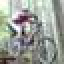

In [0]:
PIL.Image.open(('/content/DeOldify/cifar_imgs_final_small3/img_7518.jpg')).resize((64,64))

img_204 (face)

In [0]:
#!mkdir /content/DeOldify/result


In [0]:
from matplotlib.pyplot import imshow
bw_dir = 'cifar_imgs_final_small2/bandw'
bw_imgs = os.listdir(bw_dir)[:3]
print(bw_imgs)
# print(os.getcwd())
for img in bw_imgs:
  impath = '/'.join([bw_dir, img])
  im = PIL.Image.open(impath)
  
  pred = learn_gen.predict(im)
  # imshow(im)
  imshow(pred)
  